In [1]:
using Plots, StatsPlots
include("src/SFGP_classification.jl")
using Flux
using StatsBase
using CSV, DataFrames

In [2]:
df = Matrix(CSV.File("./data/banana.csv") |> DataFrame)[:,1:3]
X = transpose(df)[1:2,:]
y = (transpose(df)[3:3,:] .+ 1) ./2

1×5300 Matrix{Float64}:
 0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  …  1.0  1.0  1.0  1.0  1.0  0.0  1.0

In [3]:
function observed(mm::SFGP,m,s)
    probs = getProbs(m,s,mm.lower,mm.upper)[:]
    vals = (mm.vals)[:]
    
    dist = DiscreteNonParametric(vals,probs)
    
    mm = mean(dist)
    ss = std(dist)
    lower = quantile(dist,0.05)
    upper = quantile(dist,0.95)
    
    return mm,ss,lower,upper,dist
end

observed (generic function with 1 method)

3193.878905869475
2693.7537649099404
2132.8637320374896
2100.700585841994
1798.7531371388532
1807.6558743053652
1667.7310909902496
1767.2704768680492
1588.4436243751493
1576.9911948775891
1557.7638149863085
1582.2135887836919
1564.059353933781
1536.0580780633804


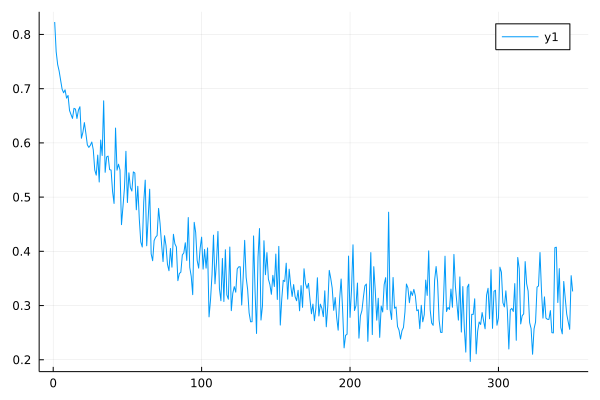

In [4]:
import Random
Random.seed!(1234)

sfgp = SFGP(SVGP(10,2),100,5)

x1g = collect(range(-4,4,length=50))
x2g = collect(range(-4,4,length=50))
x1grid = (x1g' .* ones(length(x2g)))[:] 
x2grid = (ones(length(x1g))' .* x2g)[:]
Xgrid = Matrix(transpose(hcat(x1grid,x2grid)))

params = Flux.params(sfgp)
opt = ADAM(0.05)


losses = []


for i in 1:350
    grads = Zygote.gradient(() -> sample_elbo(sfgp,X,y),params)
    Flux.Optimise.update!(opt,params,grads)
    push!(losses,sample_elbo(sfgp,X,y))
    
    if i%25==0
        println(elbo(sfgp,X,y))
    end
end

plot(losses)

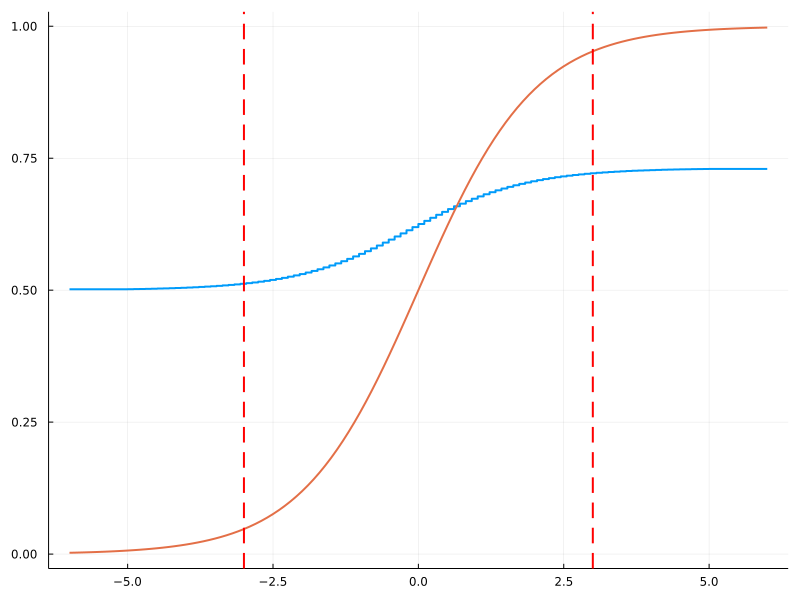

In [5]:
plot(vcat(-6,sfgp.upper[1:end-1],6),σ.(vcat(sfgp.vals[1],sfgp.vals)),legend=:none, linetype=:steppre,size=(800,600),lw=2,fmt=:png)

plot!(collect(-6:0.1:6),σ.(collect(-6:0.1:6)),lw=2)
vline!([-3,3],color=:red,s=:dash,lw=2)

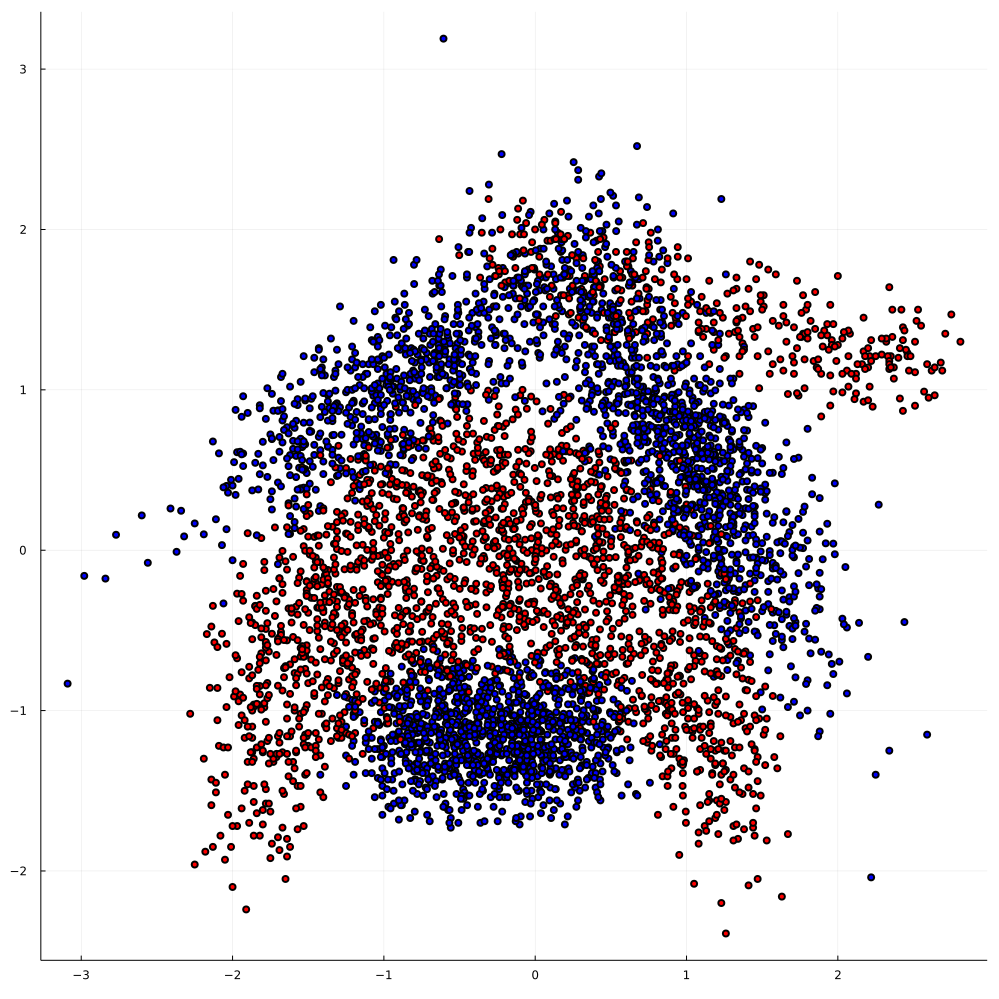

In [50]:
scatter(X[1,:],X[2,:], zcolor = Int.(round.(y[:])), legend=:none, c = :bwr, size = (1000,1000), fmt=:png)

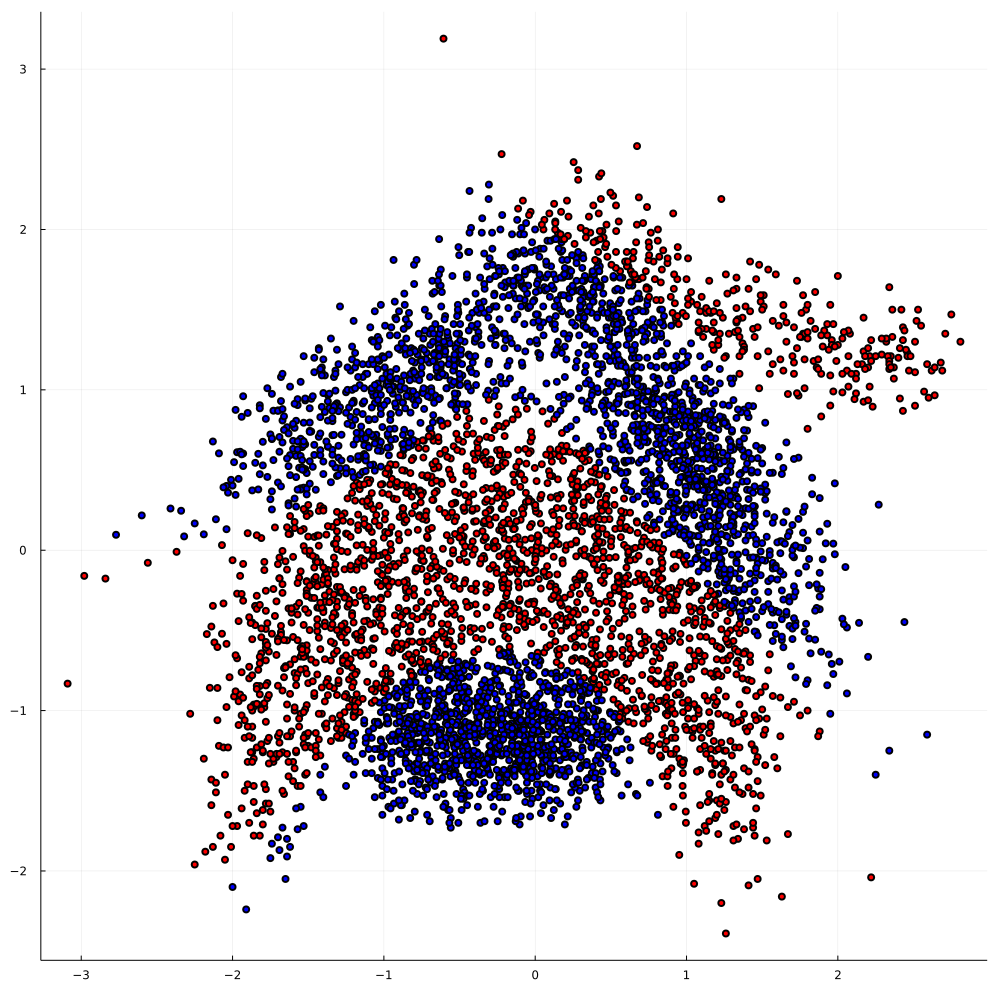

In [51]:
m,S = sfgp.gp(X)
s = sqrt.(diag(S))
scatter(X[1,:],X[2,:], zcolor = Int.(round.([observed(sfgp,z[1],z[2])[1] for z in zip(m[:],s[:])])), legend=:none,
c = :bwr, size=(1000,1000), fmt=:png)

In [52]:
function getval(x,y,val=1)
    
    m,S = sfgp.gp([x,y][:,:])
    s = sqrt.(S)
    return observed(sfgp,m[1],s[1])[val]
    
end

getval (generic function with 2 methods)

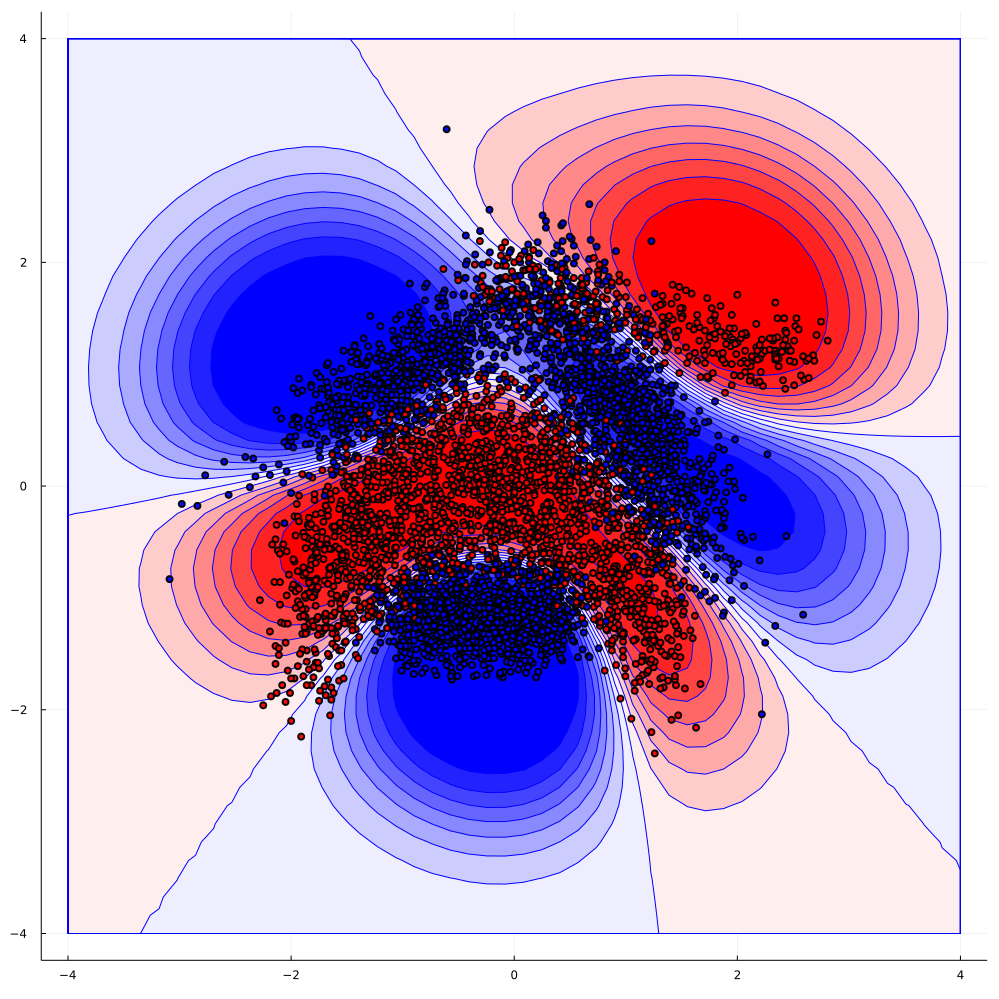

In [53]:
contourf(x1g,x2g, (x,y)->(getval(x,y,1)),c=:bwr,size=(1000,1000),colorbar=:none)
Plots.scatter!(X[1,:],X[2,:], zcolor = Int.(round.(y[:])), legend=:none,markersize = 3.5, alpha=0.95, c = :bwr, fmt=:png)

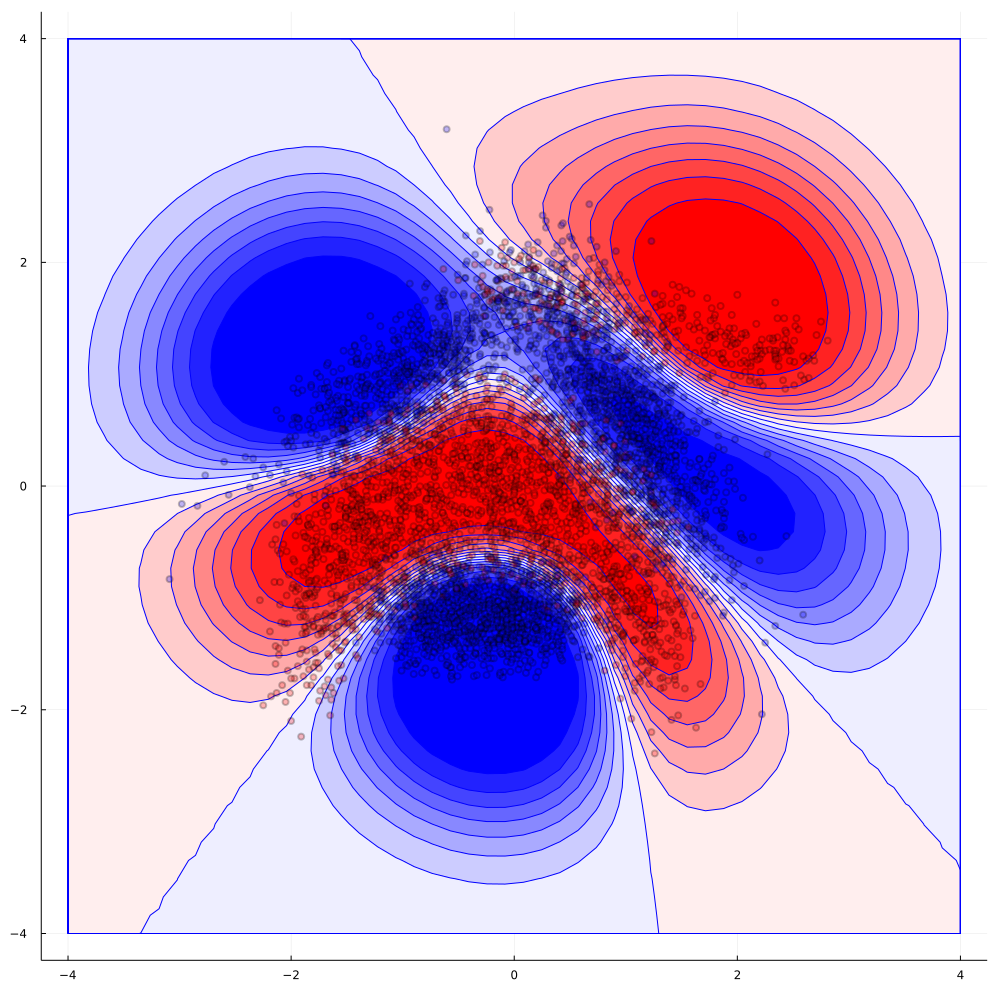

In [54]:
contourf(x1g,x2g, (x,y)->(getval(x,y,1)),c=:bwr,size=(1000,1000),colorbar=:none)
Plots.scatter!(X[1,:],X[2,:], zcolor = Int.(round.(y[:])), legend=:none,markersize = 3.5, alpha=0.25, c = :bwr, fmt=:png)

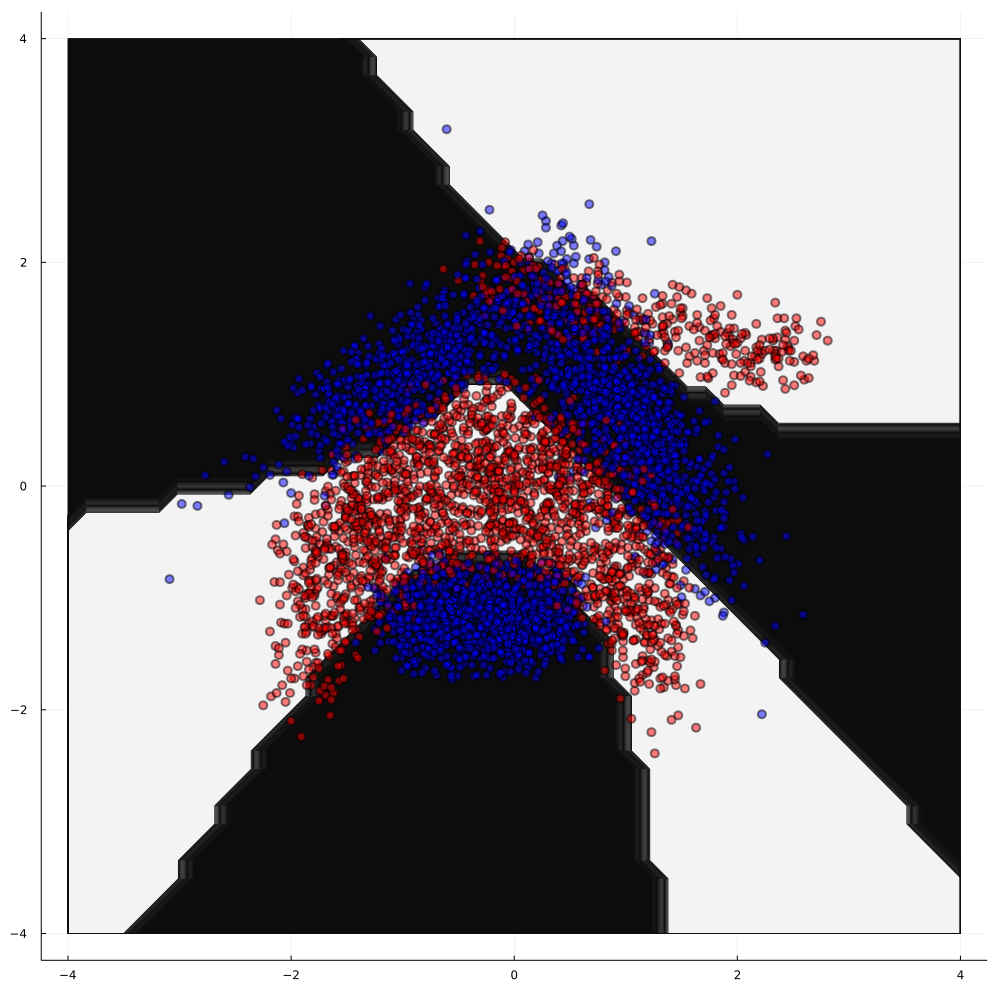

In [55]:
contourf(x1g,x2g, (x,y)->round(getval(x,y,1)),size = (1000,1000), colorbar = :none, c = :grays)

Plots.scatter!(X[1,:],X[2,:], zcolor = Int.(round.(y[:])), legend=:none,markersize = 5, alpha=0.5, c=:bwr, fmt = :png)

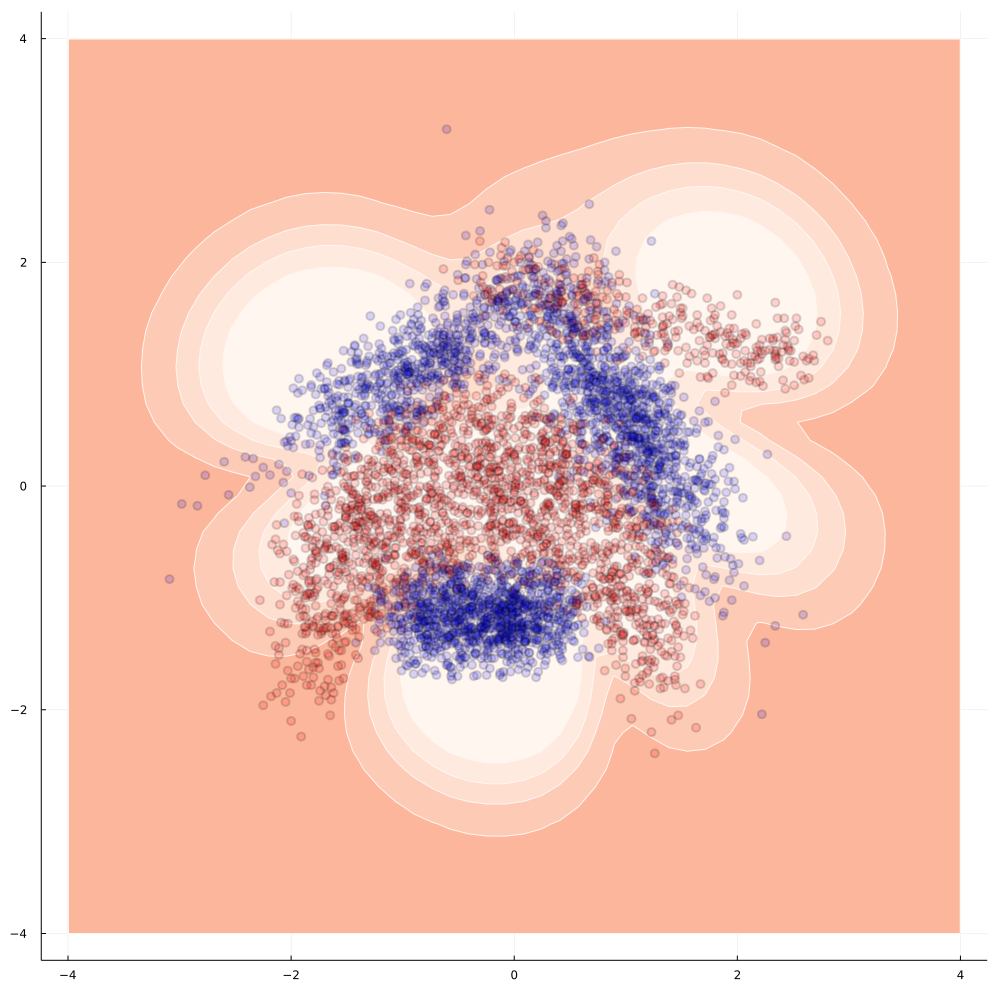

In [56]:
Plots.contourf(x1g,x2g, (x,y)->(getval(x,y,2)),size = (1000,1000), colorbar = :none, c = :Reds_9)

Plots.scatter!(X[1,:],X[2,:], zcolor = Int.(round.(y[:])), legend=:none,markersize = 5, alpha = 0.15, c = :bwr, fmt = :png)

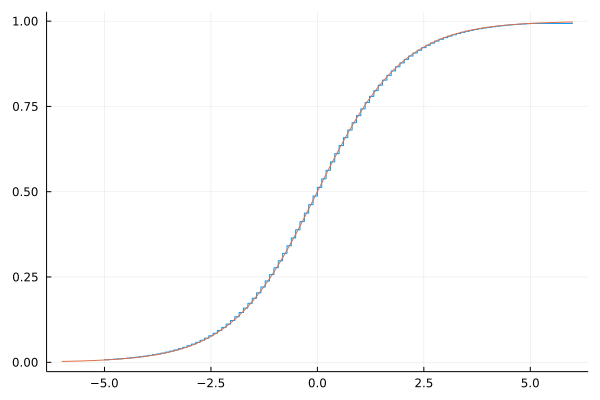

In [57]:
plot(vcat(sfgp.upper[1:end-1],sfgp.upper[end-1]+1),(sfgp.vals),legend=:none, linetype=:steppre)
plot!(collect(-6:0.1:6),σ.(collect(-6:0.1:6)))
